2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 3s 1ms/step
  Model  Noise      RMSE       MAE        R²
0   MLP   0.05  2.376095  1.342353  0.812755
1   MLP   0.10  2.739168  1.535286  0.799454
2   MLP   0.20  3.930630  2.195280  0.753174


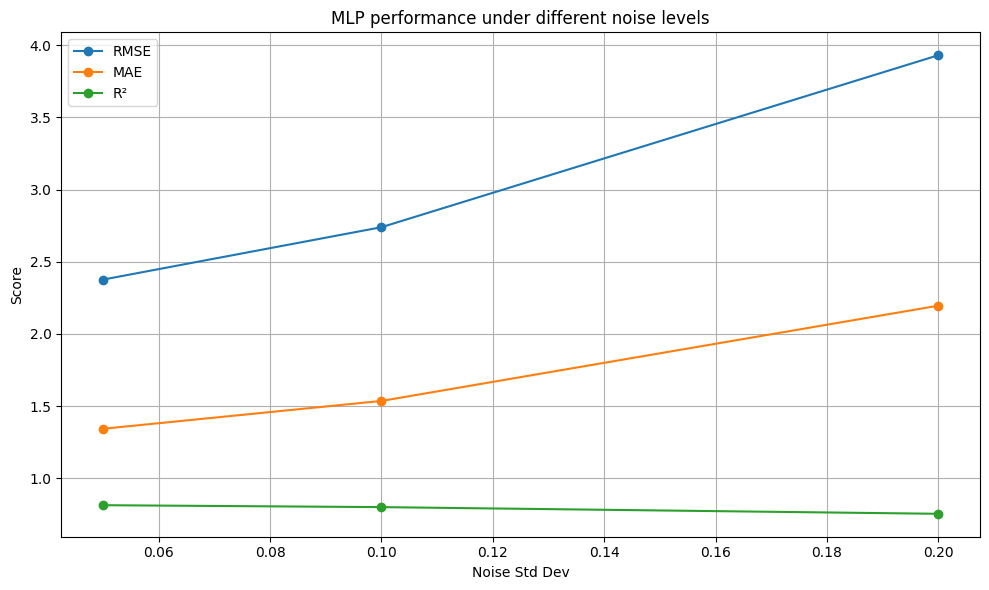

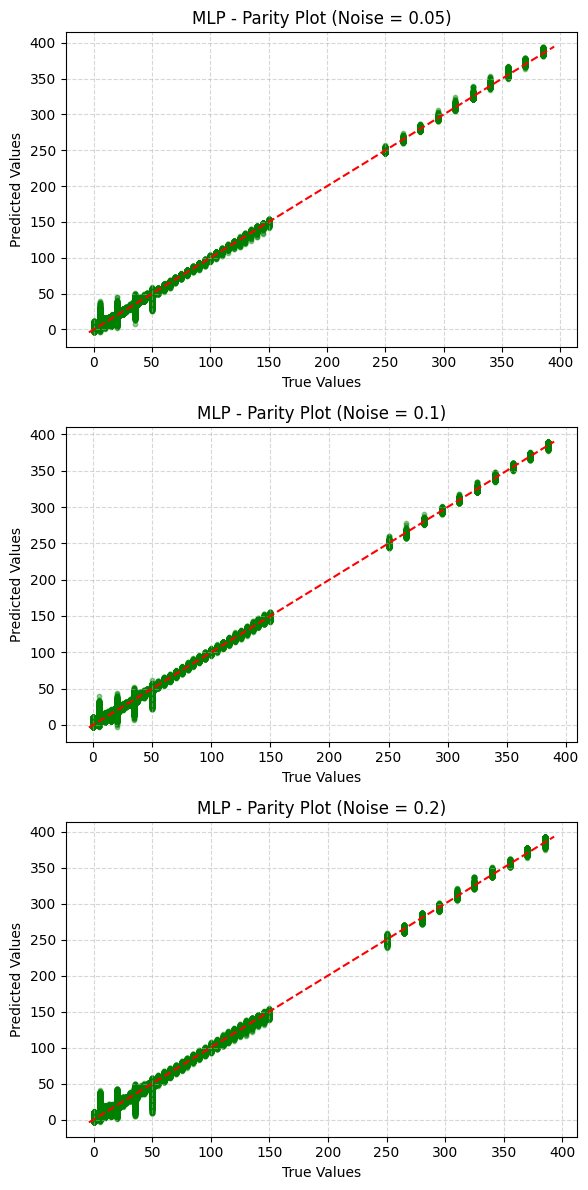

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Data inladen
X = np.load('/content/drive/MyDrive/Colab Notebooks/symmetric_line_grating_database.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/symmetric_line_grating_geometry.npy')

# Flatten & scale
X_flat = X.reshape((X.shape[0], -1))
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_flat)

# Train/val split
X_temp, X_test, y_temp, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Resulten bijhouden
results = []
noise_levels = [0.05, 0.1, 0.2]
preds_list = []  # << nodig voor parity plot

for noise_std in noise_levels:
    X_train_noisy = X_train + np.random.normal(0, noise_std, size=X_train.shape)

    model = Sequential([
        Input(shape=(X_train.shape[1],)),
        Dense(256, activation='relu'),
        Dense(128, activation='relu'),
        Dense(64, activation='relu'),
        Dense(y.shape[1])
    ])
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    es = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    model.fit(X_train_noisy, y_train, validation_data=(X_val, y_val),
              epochs=100, batch_size=32, callbacks=[es], verbose=0)

    preds = model.predict(X_val)
    preds_list.append(preds)  # << voeg toe aan lijst voor plotting

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    results.append(['MLP', noise_std, rmse, mae, r2])

# Print resultaten als tabel
df = pd.DataFrame(results, columns=['Model', 'Noise', 'RMSE', 'MAE', 'R²'])
print(df)

# Plot performance metrics vs. noise levels
metrics = ['RMSE', 'MAE', 'R²']
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.plot(df['Noise'], df[metric], marker='o', label=metric, color=colors[i])

plt.title("MLP performance under different noise levels")
plt.xlabel("Noise Std Dev")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  Parity plot functie (onder elkaar)
def plot_parity_per_noise_vertical(y_true, preds_list, noise_levels, model_name='MLP'):
    plt.figure(figsize=(6, 4 * len(noise_levels)))
    for i, (noise, y_pred) in enumerate(zip(noise_levels, preds_list)):
        plt.subplot(len(noise_levels), 1, i + 1)
        plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.4, color='green', s=10)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Parity Plot (Noise = {noise})')
        plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#  Parity plots genereren
plot_parity_per_noise_vertical(y_val, preds_list, noise_levels, model_name='MLP')



2205/2205 ━━━━━━━━━━━━━━━━━━━━ 6s 2ms/step
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
2205/2205 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
  Model  Noise      RMSE       MAE        R²
0   CNN   0.05  3.384131  1.902720  0.769854
1   CNN   0.10  3.722422  2.087302  0.754853
2   CNN   0.20  4.897576  2.760283  0.704586


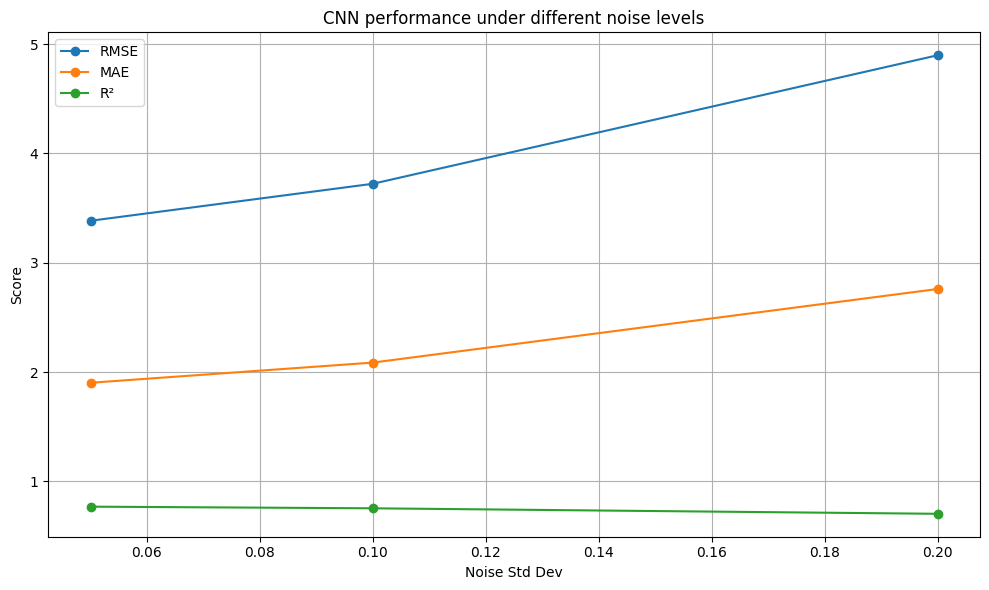

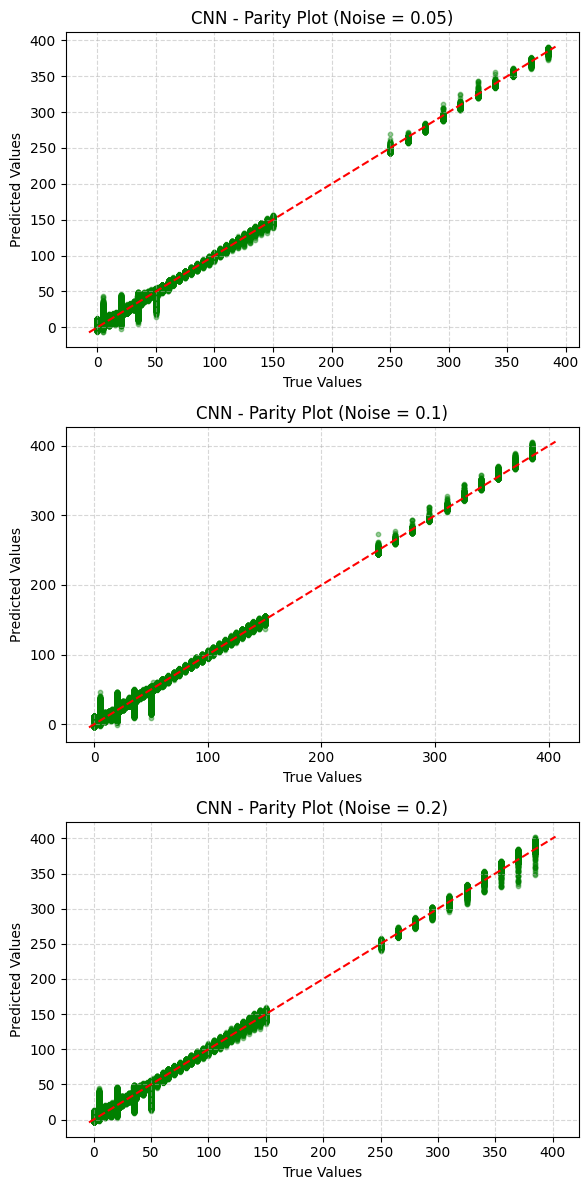

In [2]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Input
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

# Data inladen
X = np.load('/content/drive/MyDrive/Colab Notebooks/symmetric_line_grating_database.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/symmetric_line_grating_geometry.npy')

# Split
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Schalen
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train.reshape(X_train.shape[0], -1)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(X_val.shape[0], -1)).reshape(X_val.shape)

# Resulten en voorspellingen per noise level
results = []
preds_list = []
noise_levels = [0.05, 0.1, 0.2]

for noise_std in noise_levels:
    X_train_noisy = X_train_scaled + np.random.normal(0, noise_std, size=X_train_scaled.shape)
    X_train_input = np.expand_dims(X_train_noisy, axis=-1)
    X_val_input = np.expand_dims(X_val_scaled, axis=-1)

    inp = Input(shape=X_train_input.shape[1:])
    x = Conv2D(32, (2,2), activation='relu', padding='same')(inp)
    x = MaxPooling2D((1,1))(x)
    x = Conv2D(64, (2,2), activation='relu', padding='same')(x)
    x = MaxPooling2D((1,1))(x)
    x = Conv2D(128, (2,2), activation='relu', padding='same')(x)
    x = MaxPooling2D((1,1))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dense(64, activation='relu')(x)
    x = Dense(32, activation='relu')(x)
    out = Dense(y.shape[1], activation='linear')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(optimizer='adam', loss='mse')
    es = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

    model.fit(X_train_input, y_train, validation_data=(X_val_input, y_val),
              epochs=20, batch_size=32, callbacks=[es], verbose=0)

    preds = model.predict(X_val_input)
    preds_list.append(preds)  # Voor parity plots

    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    results.append(['CNN', noise_std, rmse, mae, r2])

# Resultaten als tabel
df = pd.DataFrame(results, columns=['Model', 'Noise', 'RMSE', 'MAE', 'R²'])
print(df)

# Performance plot
metrics = ['RMSE', 'MAE', 'R²']
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.plot(df['Noise'], df[metric], marker='o', label=metric, color=colors[i])

plt.title("CNN performance under different noise levels")
plt.xlabel("Noise Std Dev")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#  Parity plot functie
def plot_parity_per_noise_vertical(y_true, preds_list, noise_levels, model_name='CNN'):
    plt.figure(figsize=(6, 4 * len(noise_levels)))
    for i, (noise, y_pred) in enumerate(zip(noise_levels, preds_list)):
        plt.subplot(len(noise_levels), 1, i + 1)
        plt.scatter(y_true.flatten(), y_pred.flatten(), alpha=0.4, color='green', s=10)
        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')
        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Parity Plot (Noise = {noise})')
        plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

#  Parity plots tonen
plot_parity_per_noise_vertical(y_val, preds_list, noise_levels, model_name='CNN')



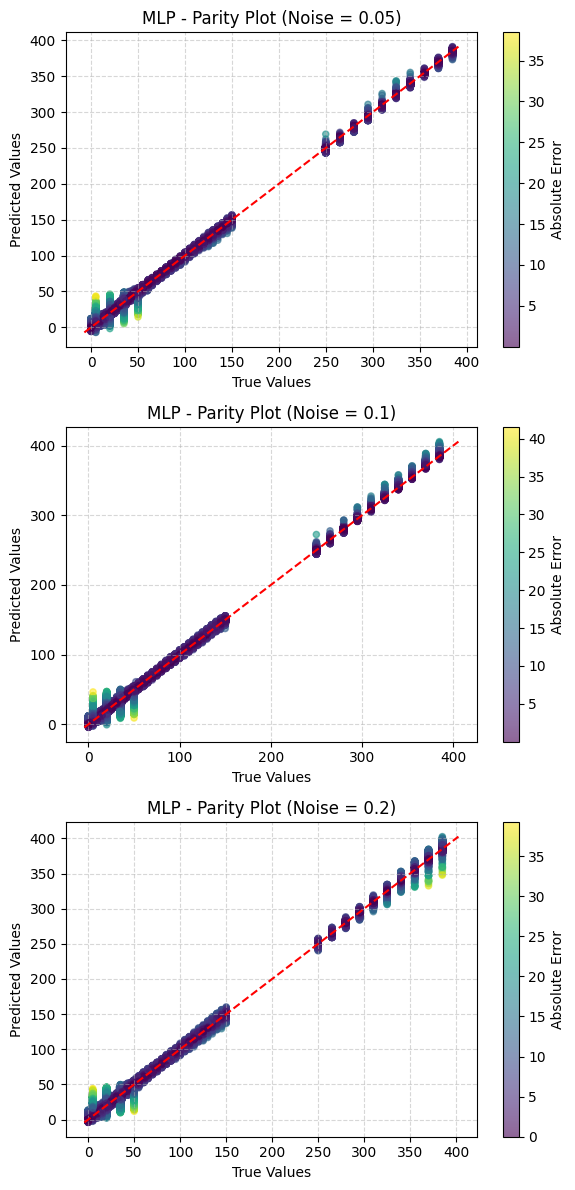

In [6]:
import matplotlib.pyplot as plt
import numpy as np

#  Parity plot functie met foutkleur (onder elkaar)
def plot_parity_per_noise_vertical(y_true, preds_list, noise_levels, model_name='MLP'):
    plt.figure(figsize=(6, 4 * len(noise_levels)))
    for i, (noise, y_pred) in enumerate(zip(noise_levels, preds_list)):
        abs_error = np.abs(y_pred.flatten() - y_true.flatten())

        plt.subplot(len(noise_levels), 1, i + 1)
        scatter = plt.scatter(
            y_true.flatten(), y_pred.flatten(),
            c=abs_error, cmap='viridis', alpha=0.6, s=20
        )

        min_val = min(y_true.min(), y_pred.min())
        max_val = max(y_true.max(), y_pred.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')

        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Parity Plot (Noise = {noise})')
        plt.grid(True, linestyle='--', alpha=0.5)
        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')

    plt.tight_layout()
    plt.show()
plot_parity_per_noise_vertical(y_val, preds_list, noise_levels, model_name='MLP')  # of MLP, XGBoost


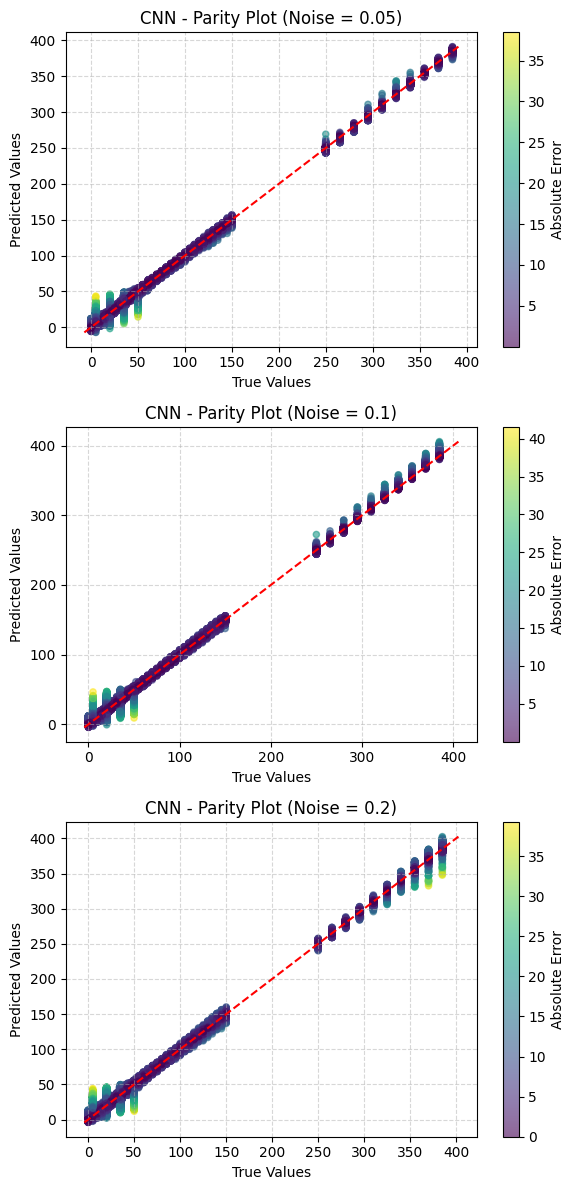

In [4]:
import matplotlib.pyplot as plt
import numpy as np

#  Verbeterde parity plot-functie (onder elkaar, met kleur op fout)
def plot_parity_per_noise_vertical(y_true, preds_list, noise_levels, model_name='CNN'):
    plt.figure(figsize=(6, 4 * len(noise_levels)))

    for i, (noise, y_pred) in enumerate(zip(noise_levels, preds_list)):
        true_flat = y_true.flatten()
        pred_flat = y_pred.flatten()
        abs_error = np.abs(pred_flat - true_flat)

        plt.subplot(len(noise_levels), 1, i + 1)
        scatter = plt.scatter(
            true_flat,
            pred_flat,
            c=abs_error,
            cmap='viridis',
            alpha=0.6,
            s=20
        )

        min_val = min(true_flat.min(), pred_flat.min())
        max_val = max(true_flat.max(), pred_flat.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')

        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Parity Plot (Noise = {noise})')
        plt.grid(True, linestyle='--', alpha=0.5)

        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')

    plt.tight_layout()
    plt.show()
plot_parity_per_noise_vertical(y_val, preds_list, noise_levels, model_name='CNN')



Training with noise level 0.05...

Training with noise level 0.1...

Training with noise level 0.2...

XGBoost performance summary:
     Model  Noise      RMSE       MAE        R²
0  XGBoost   0.05  6.932410  4.097261  0.739902
1  XGBoost   0.10  8.221346  5.178403  0.666416
2  XGBoost   0.20  9.526326  6.572791  0.581416


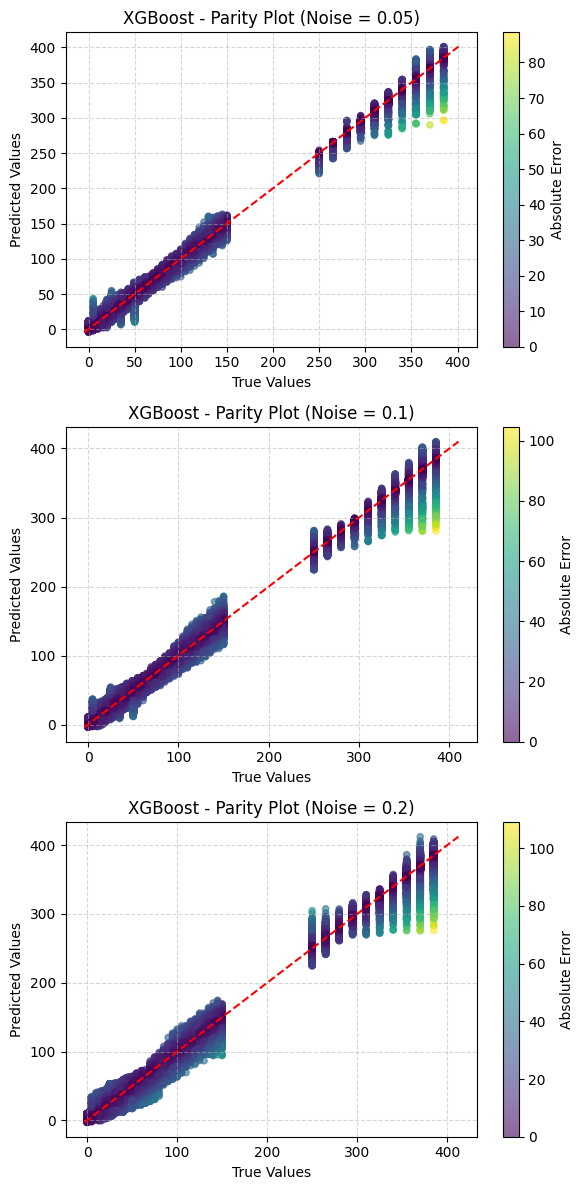

In [1]:


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.multioutput import MultiOutputRegressor
from xgboost import XGBRegressor

X = np.load('/content/drive/MyDrive/Colab Notebooks/symmetric_line_grating_database.npy')
y = np.load('/content/drive/MyDrive/Colab Notebooks/symmetric_line_grating_geometry.npy')

X = X.reshape(X.shape[0], -1)

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_base, X_val, y_train_base, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42)

# Noise levels
noise_levels = [0.05, 0.1, 0.2]
results = []
preds_list = []

# Hyperparameters
param_grid = {
    'estimator__n_estimators': [350],
    'estimator__max_depth': [9],
    'estimator__learning_rate': [0.2],
}

# Loop over noise levels
for noise in noise_levels:
    print(f"\nTraining with noise level {noise}...")

    X_train = X_train_base + np.random.normal(0, noise, X_train_base.shape)

    base_model = XGBRegressor(
        random_state=42,
        verbosity=0,
        tree_method='hist',
        device='cuda'
    )
    wrapper = MultiOutputRegressor(base_model)

    grid = GridSearchCV(
        estimator=wrapper,
        param_grid=param_grid,
        cv=5,
        scoring='r2',
        verbose=0,
        n_jobs=1
    )

    grid.fit(X_train, y_train_base)
    best_model = grid.best_estimator_
    preds = best_model.predict(X_val)
    preds_list.append(preds)

    # Eval
    rmse = np.sqrt(mean_squared_error(y_val, preds))
    mae = mean_absolute_error(y_val, preds)
    r2 = r2_score(y_val, preds)
    results.append(['XGBoost', noise, rmse, mae, r2])

df = pd.DataFrame(results, columns=['Model', 'Noise', 'RMSE', 'MAE', 'R²'])
print("\nXGBoost performance summary:")
print(df)

def plot_parity_per_noise_vertical(y_true, preds_list, noise_levels, model_name='XGBoost'):
    plt.figure(figsize=(6, 4 * len(noise_levels)))

    for i, (noise, y_pred) in enumerate(zip(noise_levels, preds_list)):
        true_flat = y_true.flatten()
        pred_flat = y_pred.flatten()
        abs_error = np.abs(pred_flat - true_flat)

        plt.subplot(len(noise_levels), 1, i + 1)
        scatter = plt.scatter(
            true_flat,
            pred_flat,
            c=abs_error,
            cmap='viridis',
            alpha=0.6,
            s=20
        )

        min_val = min(true_flat.min(), pred_flat.min())
        max_val = max(true_flat.max(), pred_flat.max())
        plt.plot([min_val, max_val], [min_val, max_val], 'r--')

        plt.xlabel('True Values')
        plt.ylabel('Predicted Values')
        plt.title(f'{model_name} - Parity Plot (Noise = {noise})')
        plt.grid(True, linestyle='--', alpha=0.5)

        cbar = plt.colorbar(scatter)
        cbar.set_label('Absolute Error')

    plt.tight_layout()
    plt.show()

plot_parity_per_noise_vertical(y_val, preds_list, noise_levels, model_name='XGBoost')



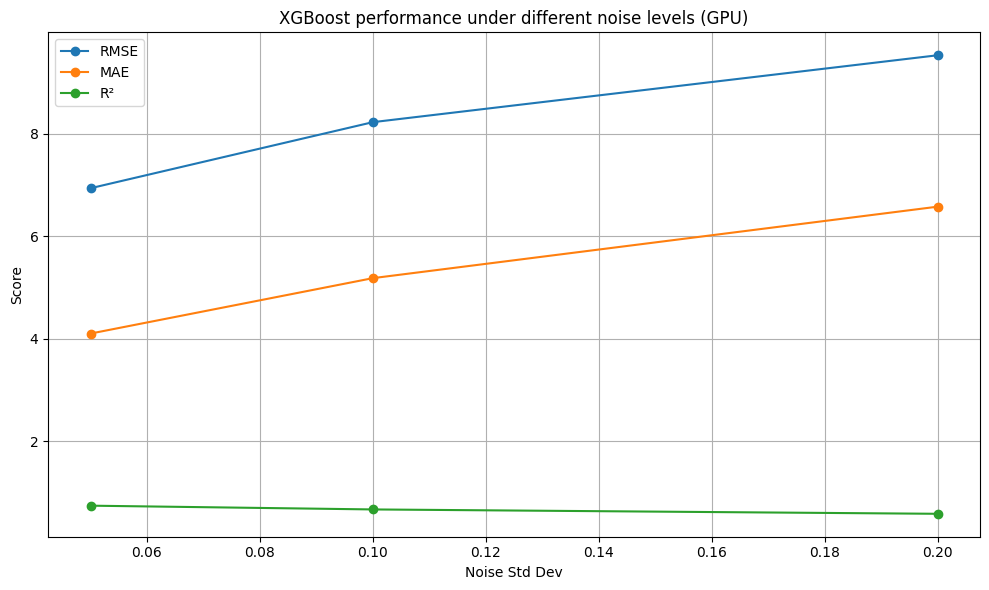

In [2]:
metrics = ['RMSE', 'MAE', 'R²']
colors = ['tab:blue', 'tab:orange', 'tab:green']

plt.figure(figsize=(10, 6))
for i, metric in enumerate(metrics):
    plt.plot(df['Noise'], df[metric], marker='o', label=metric, color=colors[i])

plt.title("XGBoost performance under different noise levels (GPU)")
plt.xlabel("Noise Std Dev")
plt.ylabel("Score")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
